In [1]:
import os
import tensorflow as tf
import cProfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# eager is on by default
tf.executing_eagerly()

True

In [3]:
# tensorflow ops return immediately
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


In [4]:
a = tf.constant([[1, 2], [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [5]:
# broadcasting
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [6]:
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [7]:
# tf.tensor can be used with numpy
c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [8]:
# can get numpy from tf.tensor
print(a.numpy())

[[1 2]
 [3 4]]


# Eager training

### computing gradients

In [9]:
w = tf.Variable([[1.0]])

# use tape to record forward ops, and use tape to compute gradients later 
with tf.GradientTape() as tape:
    loss = w * w

# use tape to compute gradient, can only compute 1 gradient
grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


### train

In [10]:
# get data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

# normalize data and convert to tf.dataset
dataset = tf.data.Dataset.from_tensor_slices((tf.cast(mnist_images[..., tf.newaxis]/255, tf.float32), tf.cast(mnist_labels, tf.int64)))
# shuffle and batch
dataset = dataset.shuffle(1000).batch(32)

In [11]:
# build model
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3, 3], activation='relu', input_shape=(None, None, 1)),
    tf.keras.layers.Conv2D(16, [3, 3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

In [12]:
# check model output
for images, labels in dataset.take(1):
    print('Logits: ',mnist_model(images[0:1]).numpy())

Logits:  [[-0.03280016  0.01187571  0.00687724  0.0270856  -0.01094467 -0.01811531
   0.02061419 -0.0122699  -0.01563479  0.01805109]]


In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_history = []

# implement own training loop instead of model.fit()
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)

        # assert output shape
        tf.debugging.assert_equal(logits.shape, (32, 10))
        
        # calculate cost
        loss_value = loss_object(labels, logits)

    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [14]:
def train(epochs):
    for epoch in range(epochs):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print('Epoch {} completed'.format(epoch))

In [15]:
train(epochs=3)

Epoch 0 completed
Epoch 1 completed
Epoch 2 completed


Text(0, 0.5, 'Loss [entropy')

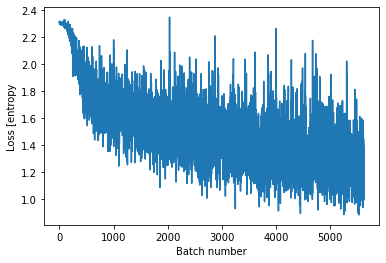

In [16]:
plt.plot(loss_history)
plt.xlabel('Batch number')
plt.ylabel('Loss [entropy')

### saving

In [17]:
mnist_model.save_weights('weights')
status = mnist_model.load_weights('weights')

In [18]:
x = tf.Variable(10.)

# specify varaible to store in checkpoint
checkpoint = tf.train.Checkpoint(x=x)

In [19]:
x.assign(2.)
checkpoint_path = './ckpt/'
checkpoint.save(checkpoint_path)

'./ckpt/-1'

In [20]:
x.assign(11.)
# restore from checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


In [21]:
# store and restore model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

root = tf.train.Checkpoint(optimizer=optimizer, model=model)
root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

### summaries and TensorBoard

In [24]:
logdir = "./tb/"
writer = tf.summary.create_file_writer(logdir)

steps = 1000
with writer.as_default():
    for i in range(steps):
        step = i + 1
        loss = 1 - 0.001 * step
        # write summary every 100 steps
        if step % 100 == 0:
            tf.summary.scalar('loss', loss, step=step)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [3, 4]])>